In [93]:
import cv2 as cv
import numpy as np
import math
import matplotlib.pyplot as plt
import tensorflow as tf
import random


In [94]:
def display(img):
    cv.imshow('img', img)
    cv.waitKey(0)
    cv.destroyAllWindows()

def resize(img,scale = 0.3):
    width = int(img.shape[1]*scale)
    height = int(img.shape[0]*scale)
    dim = (width,height)
    return cv.resize(img,dim,interpolation = cv.INTER_AREA)

def distance(cord1,cord2):
   cord1= np.array(cord1)
   cord2 = np.array(cord2)
   return math.sqrt(np.sum((cord1-cord2)**2))

In [95]:
img = cv.imread(r'D:\ACtive\Hand_Writing_Replicator\MachineLearning\IMAGES\cap_alpha.jpg')
img = resize(img)

gray = cv.cvtColor(img, cv.COLOR_BGR2GRAY)
edged = cv.Canny(gray, 50, 200)

threshold_value = 128
_, binary_image = cv.threshold(gray, threshold_value, 255, cv.THRESH_BINARY)
inputBINARY =cv.bitwise_not(binary_image)
contours,_ = cv.findContours(edged,cv.RETR_EXTERNAL,cv.CHAIN_APPROX_NONE)


In [96]:
cords =[]
test = img.copy()
for cont in contours:
    x,y,w,h = cv.boundingRect(cont)
    cords.append([x,y])
print(cords)
print(len(cords))
cords = np.array(cords)


[[266, 456], [150, 452], [399, 440], [657, 437], [616, 434], [612, 429], [504, 419], [508, 414], [619, 410], [647, 406], [612, 403], [147, 341], [273, 336], [380, 333], [265, 332], [377, 328], [496, 300], [490, 296], [600, 285], [677, 276], [796, 267], [149, 215], [262, 209], [364, 190], [480, 183], [805, 178], [576, 167], [664, 156], [778, 147], [151, 80], [255, 71], [345, 68], [557, 60], [446, 53], [545, 40], [646, 23], [745, 20], [1025, 0]]
38


# Distance by euclidian formula

In [97]:
Dthresh = 30

distanceMatrix=[]

for cor1 in cords:

    temp=[]
    for cor2 in cords:
        dist = distance(cord1=cor1,cord2=cor2)
        if dist <= Dthresh:
            temp.append(1)
        else:
            temp.append(0)
        
        
    distanceMatrix.append(temp)

distanceMatrix = np.array(distanceMatrix)
print(distanceMatrix.shape)


(38, 38)


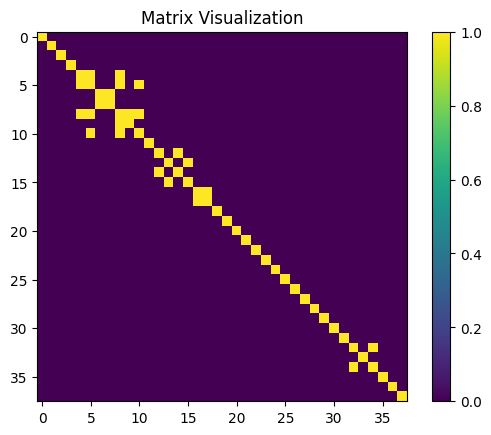

In [98]:

plt.imshow(distanceMatrix, cmap='viridis', interpolation='nearest')
plt.colorbar()
plt.title('Matrix Visualization')
plt.show()

# Finding nearby contours by DPFS algo

In [99]:
visited = []  # stores indexes
connected = []  # stores array of connected index
collector = []  # stores indexes

## uses dpfs
def findconnected(submatrix,idx):

    if idx not in visited:

        visited.append(idx)

        if idx not in collector:
            collector.append(idx)

        for i in range(len(submatrix)):

            if submatrix[i]==1:
                if i not in visited:
                    collector.append(i)
        
        for nodeidx in collector:
            if nodeidx not in visited:
                findconnected(distanceMatrix[nodeidx],nodeidx)



for runidx in range(len(distanceMatrix)):

    findconnected(distanceMatrix[runidx],runidx)
    
    if len(collector)!=0:
        connected.append(collector)
    collector=[]

print(connected)
print(len(connected))
    


[[0], [1], [2], [3], [4, 5, 8, 8, 10, 9, 10], [6, 7], [11], [12, 14], [13, 15], [16, 17], [18], [19], [20], [21], [22], [23], [24], [25], [26], [27], [28], [29], [30], [31], [32, 34], [33], [35], [36], [37]]
29


# Merging Contours - Predict with model - save into arrays

In [100]:
def padding(image):
    
    original_rows, original_cols = image.shape
    padding_rows = 10  
    padding_cols = 10  
    padded_rows = original_rows + 2 * padding_rows
    padded_cols = original_cols + 2 * padding_cols
    padded_image = np.zeros((padded_rows, padded_cols), dtype=np.uint8)
    padded_image[padding_rows:padding_rows + original_rows, padding_cols:padding_cols + original_cols] = image
    image = cv.resize(padded_image,(28,28))
    return image

In [101]:
ALP_arr = []
Dimn_arr =[]
for i in range(26):
    ALP_arr.append([])
    Dimn_arr.append([])
# print(Dimn_arr,len(ALP_arr))
alphabets = [chr(y) for y in range(ord("A"),ord("Z")+1) ]

model = tf.keras.models.load_model(r"D:\ACtive\Hand_Writing_Replicator\MachineLearning\Models\CAP_9997.h5")

Similar_contour_cluster = []
similar_contour_dimen = []

for con in connected:
    temp = np.array([])

    for idx in con:
        if len(temp)==0:
            temp = contours[idx]
        else:
            temp = np.concatenate((temp,contours[idx]))
    
    x,y,w,h = cv.boundingRect(temp)
    
    if w>12:

        Similar_contour_cluster.append(temp)
        similar_contour_dimen.append([x,y,w,h])
        
        image = inputBINARY[y:y+h,x:x+w]
        image = padding(image)        
        model_Inp = image.reshape(1,28,28)

        result =model.predict(model_Inp)
        
        # cv.drawContours(blank_image, temp, -1, (0, 255, 0), 2)
        index = np.argmax(result)
        # print(alphabets[index],[w,h])
        # display(image)
        index = np.argmax(result)
        ALP_arr[index].append(binary_image[y:y+h,x:x+w])
        Dimn_arr[index].append([w,h])
    
        
# print(similar_contour_dimen[1])
        

    


1/1 [==============================] - 0s 24ms/step


In [102]:
print(Dimn_arr)

[[[40, 58]], [[37, 59]], [[45, 49]], [[41, 49]], [[35, 48]], [], [], [[40, 53], [34, 52]], [[41, 47]], [[44, 43], [39, 60]], [[37, 44]], [], [[46, 40]], [[43, 42]], [[41, 45]], [[32, 58]], [[43, 45], [57, 47]], [[44, 57]], [[33, 48]], [], [[32, 39], [33, 43]], [[38, 42]], [[44, 39]], [[32, 38]], [[34, 51]], [[52, 43]]]


In [103]:
# for i in range(len(ALP_arr)):
#     for j in range(len(ALP_arr[i])):
#         display(ALP_arr[i][j])

# Output A4 sheet

In [104]:
inputstring = "hello my name is abhijith sj as of now i am sucessful in creating this replicator and i know there is lot more to add and i can improve many features and i am excited to learn as i move forward facing new problems and finding its solution is as always a great way to spend some time "
# inputstring="abcdefghij klmnopqrstuvwxyz"
height = 1000
margin_top = int(0.025*height)


In [105]:
# map alphabet with 0 -26
alphabet_dict = {}


alphab = "abcdefghijklmnopqrstuvwxyz0"## 0 for any un wanted noises

for i, letter in enumerate(alphab.upper()):
    alphabet_dict[letter] = i
print(alphabet_dict)

{'A': 0, 'B': 1, 'C': 2, 'D': 3, 'E': 4, 'F': 5, 'G': 6, 'H': 7, 'I': 8, 'J': 9, 'K': 10, 'L': 11, 'M': 12, 'N': 13, 'O': 14, 'P': 15, 'Q': 16, 'R': 17, 'S': 18, 'T': 19, 'U': 20, 'V': 21, 'W': 22, 'X': 23, 'Y': 24, 'Z': 25, '0': 26}


In [106]:
A4 = np.ones((height,int(height/1.4)),dtype=np.uint8)*255
start_height = margin_top
start_left = margin_top
scale = 0.5#size of font

lineheight = 100
lineheight = int(lineheight*scale)

wordspace = 30
wordspace = int(wordspace*scale)

shaped = A4.shape
for i ,lett in enumerate(inputstring.upper()):

    if(lett == " "):
            start_left = start_left+wordspace
    else:
         
        idx = alphabet_dict[lett]
        if len(ALP_arr[idx])!=0:

            variety_idx = random.randint(0,len(ALP_arr[idx])-1)

            w,h = Dimn_arr[idx][variety_idx]
            w,h = int(w*scale),int(h*scale)
            
            if(start_left+w>=shaped[1]-margin_top):
                start_left = margin_top
                start_height = start_height+lineheight

            alphimg = resize(ALP_arr[idx][variety_idx],scale)

            A4[start_height:start_height+h,start_left:start_left+w] = alphimg
            start_left = start_left+w

    
    
               

display(A4)
     
desc = input("is this good then 1 to discard 0")
if(int(desc)==1):
    fname = input("name of the image")
    fname = fname+".jpg"
    cv.imwrite(fname,A4)
    print(fname,"saved")

new aproach bug fixes.jpg saved
